In [1]:
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import chi2
from sklearn.cluster import KMeans, SpectralClustering, HDBSCAN, DBSCAN
from sklearn.decomposition import PCA
from data import FiberTrackingDataModule
from config import Config
import os
from tqdm import tqdm
from umap import UMAP
import seaborn as sns
import wandb
from models.lightning_models import TransformerAutoencoderModule_4
from lightning.pytorch.trainer import Trainer
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from matplotlib.colors import LogNorm
from sklearn.neighbors import NearestNeighbors
import kneed
import scipy.stats as stats

/home/bugsie/mambaforge/envs/FiberPhotometryAnalyzer1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize W&B and download model artifact
run = wandb.init()
artifact = run.use_artifact('bugsiesegal/fiber-tracking/model-mrsr8td7:v0', type='model')
artifact_dir = artifact.download()

wandb: Currently logged in as: bugsiesegal. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-mrsr8td7:v0, 59.09MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


In [3]:
# Set up the config
config = Config()
config.num_workers = 4
config.normalization = 'quantile'
config.num_layers = 3
config.d_model = 64
config.nhead = 4
config.dim_feedforward = 1024
config.dropout = 0.1
config.activation = 'relu'
config.latent_dim = 32
config.window_dim = 1024
config.num_workers = 4
config.data_dir = os.path.join(os.getcwd(), 'datafiles')

sample_rate = 10

In [4]:
# Load model configuration
model_config = Config.from_yaml('/home/bugsie/PycharmProjects/FiberPhotometryAnalyzer/example_configs/config_1.yaml')

In [5]:
# Load the model from checkpoint
model = TransformerAutoencoderModule_4.load_from_checkpoint(os.path.join(artifact_dir, 'model.ckpt'),
                                                            config=model_config)

/home/bugsie/mambaforge/envs/FiberPhotometryAnalyzer1/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
# Load tracking data
config.batch_size = 2 ** 9
config.use_tracking = True
config.use_fiber = False
tracking_data_module = FiberTrackingDataModule(config)
tracking_data_module.prepare_data()
tracking_dataloader = tracking_data_module.predict_dataloader()
tracking_data = []
for data in tracking_dataloader:
    tracking_data.append(data[:, 0, :].to(torch.float16))
tracking_data = np.concatenate(tracking_data)[::sample_rate]

In [7]:
# Load fiber data
config.batch_size = 2 ** 8
config.use_tracking = False
config.use_fiber = True
fiber_data_module = FiberTrackingDataModule(config)
fiber_data_module.prepare_data()
fiber_dataloader = fiber_data_module.predict_dataloader()

In [8]:
# Encode fiber data
trainer = Trainer(precision='16-mixed')
encoded_data = trainer.predict(model, fiber_dataloader)
encoded_data = np.concatenate(encoded_data)[::sample_rate]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/bugsie/mambaforge/envs/FiberPhotometryAnalyzer1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch

Predicting DataLoader 0: 100%|██████████| 2537/2537 [05:29<00:00,  7.70it/s]


100%|██████████| 149/149 [01:34<00:00,  1.58it/s]


Elbow Point: 18


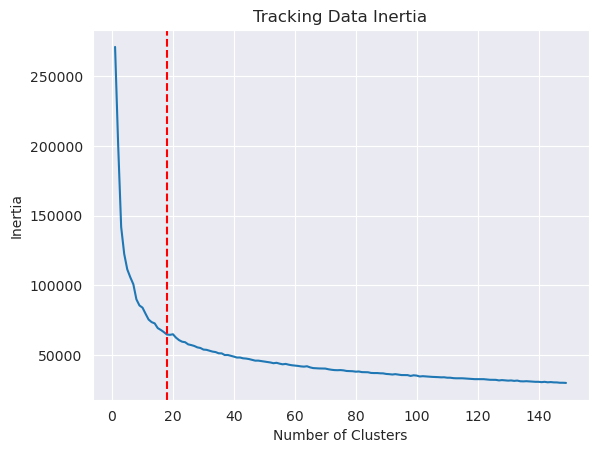

In [9]:
# Find the optimal number of clusters for the tracking data
kmeans = KMeans()
inertia = []
range_max = 150
for k in tqdm(range(1, range_max)):
    kmeans.n_clusters = k
    kmeans.fit(tracking_data)
    inertia.append(kmeans.inertia_)

# Find the elbow point
kneedle = kneed.KneeLocator(range(1, range_max), inertia, curve='convex', direction='decreasing')
print(f"Elbow Point: {kneedle.knee}")

plt.plot(range(1, range_max), inertia)
plt.axvline(kneedle.knee, color='red', linestyle='--')
plt.title('Tracking Data Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.savefig('graphs/tracking_inertia.png')
plt.show()

In [10]:
clustering_method = partial(KMeans, n_clusters=kneedle.knee)

In [11]:
tracking_clustering = clustering_method()
tracking_clustering.fit(tracking_data)
tracking_cluster_centers = tracking_clustering.cluster_centers_

In [12]:
tracking_pca = PCA(n_components=2)
tracking_data_2d = tracking_pca.fit_transform(tracking_data)
tracking_cluster_centers_2d = tracking_pca.transform(tracking_cluster_centers)
tracking_labels = tracking_clustering.labels_
tracking_pca.explained_variance_ratio_

array([0.34556431, 0.31874024])

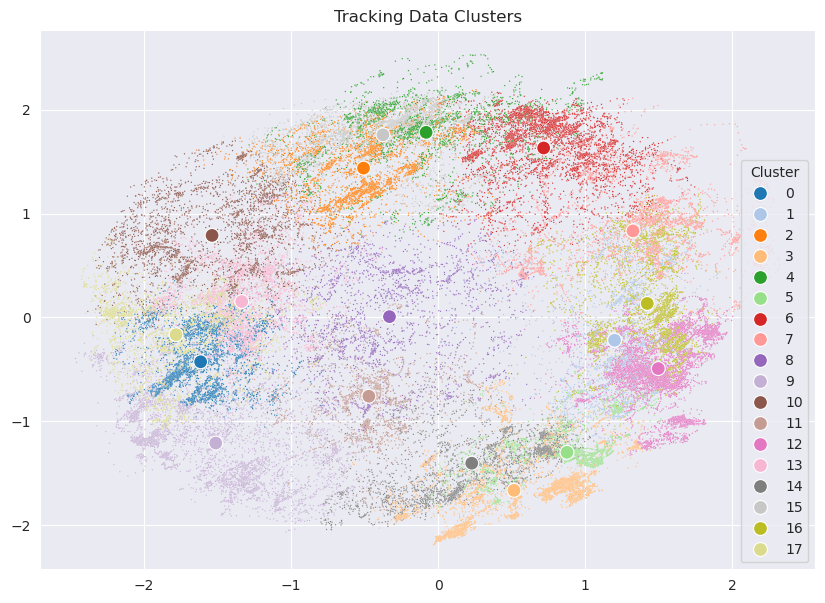

In [14]:
plt.figure(figsize=(10, 7))

# First scatter plot
scatter1 = sns.scatterplot(
    x=tracking_data_2d[:, 0], 
    y=tracking_data_2d[:, 1], 
    hue=tracking_labels, 
    s=1, 
    palette='tab20',
    legend=None  # Disable legend for the first scatter plot
)

# Second scatter plot for cluster centers
scatter2 = sns.scatterplot(
    x=tracking_cluster_centers_2d[:, 0], 
    y=tracking_cluster_centers_2d[:, 1], 
    s=100, 
    hue=range(tracking_clustering.n_clusters), 
    palette='tab20',
    legend='brief'  # Enable legend for the second scatter plot
)

# Add the legend manually
plt.legend(title='Cluster', loc='best')

plt.title('Tracking Data Clusters')
plt.savefig('graphs/tracking_clusters.png')
plt.show()

100%|██████████| 149/149 [02:15<00:00,  1.10it/s]


Elbow Point: 9


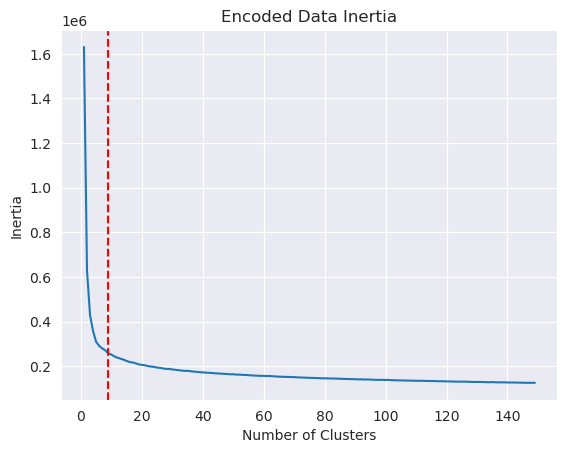

In [15]:
# Find the optimal number of clusters for the encoded data
kmeans = KMeans()
inertia = []
range_max = 150
for k in tqdm(range(1, range_max)):
    kmeans.n_clusters = k
    kmeans.fit(encoded_data)
    inertia.append(kmeans.inertia_)

# Find the elbow point
kneedle = kneed.KneeLocator(range(1, range_max), inertia, curve='convex', direction='decreasing')
print(f"Elbow Point: {kneedle.knee}")

plt.plot(range(1, range_max), inertia)
plt.axvline(kneedle.knee, color='red', linestyle='--')
plt.title('Encoded Data Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.savefig('graphs/encoded_inertia.png')
plt.show()

In [16]:
clustering_method = partial(KMeans, n_clusters=kneedle.knee)

In [17]:
encoded_clustering = clustering_method()
encoded_clustering.fit(encoded_data)

KMeans(n_clusters=np.int64(9))

In [18]:
encoded_pca = PCA(n_components=2)
encoded_pca_data = encoded_pca.fit_transform(encoded_data)
encoded_pca_cluster_centers = encoded_pca.transform(encoded_clustering.cluster_centers_)
encoded_labels = encoded_clustering.labels_

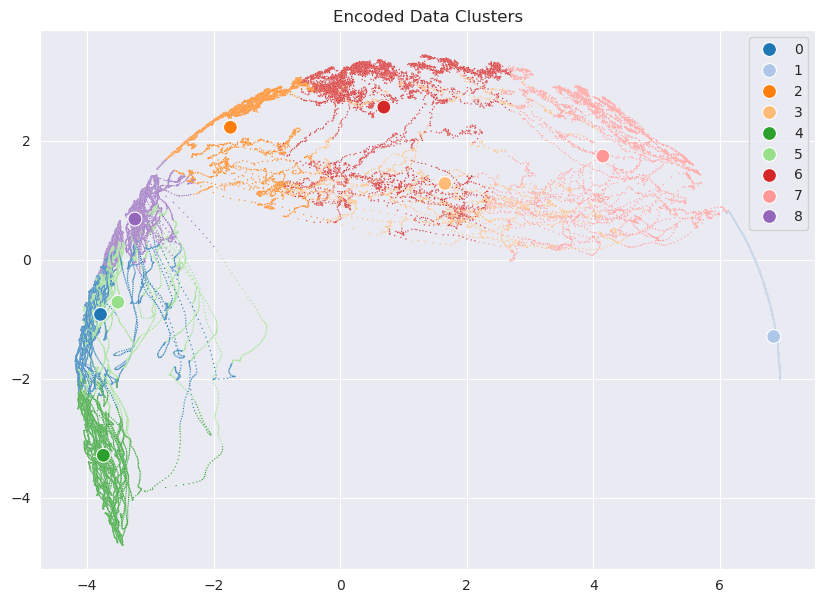

In [19]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=encoded_pca_data[:, 0], y=encoded_pca_data[:, 1], hue=encoded_clustering.labels_, s=1,
                palette='tab20', legend=None)
sns.scatterplot(x=encoded_pca_cluster_centers[:, 0], y=encoded_pca_cluster_centers[:, 1], s=100, hue=range(encoded_clustering.n_clusters),
                palette='tab20', legend='brief')
plt.title('Encoded Data Clusters')
plt.savefig('graphs/encoded_clusters.png')
plt.show()

In [20]:
# Create a contingency table
contingency_table = pd.crosstab(tracking_labels, encoded_labels, rownames=['Position Clusters'], colnames=['Brainwave Clusters'])
print(contingency_table)

Brainwave Clusters     0     1     2    3     4    5    6     7     8
Position Clusters                                                    
0                   1246     0   201    6   980  732  112     3   123
1                      8  1226   300  130    10   24  263   153   255
2                    158    36   189  225  1805   99  133   637   396
3                   1365   140    29   35   317  846  176     1  2028
4                    168   160    45  287   448  114  628   143   466
5                     53  2928    19    0    60   75  284     0    69
6                     20   213  1110  524   141  148  769  1545   348
7                     54  1252   749   81   163  152  502   392   511
8                    149   154   345  147   380  231  217    84   695
9                   1298     8   428   77   975  970  343    58   753
10                   593   168   311  125   324  278  512   163   552
11                   214  1079    67   32   124  114  194    31   262
12                  

In [21]:
# Compute Adjusted Rand Index and Normalized Mutual Information
ari = adjusted_rand_score(tracking_labels, encoded_clustering.labels_)
nmi = normalized_mutual_info_score(tracking_labels, encoded_clustering.labels_)
print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.10374386308237525
Normalized Mutual Information: 0.1896888252725824


In [22]:
chi2_stat, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Test: chi2={chi2_stat}, p-value={p}, dof={dof}")

Chi-Square Test: chi2=64836.90214185335, p-value=0.0, dof=136


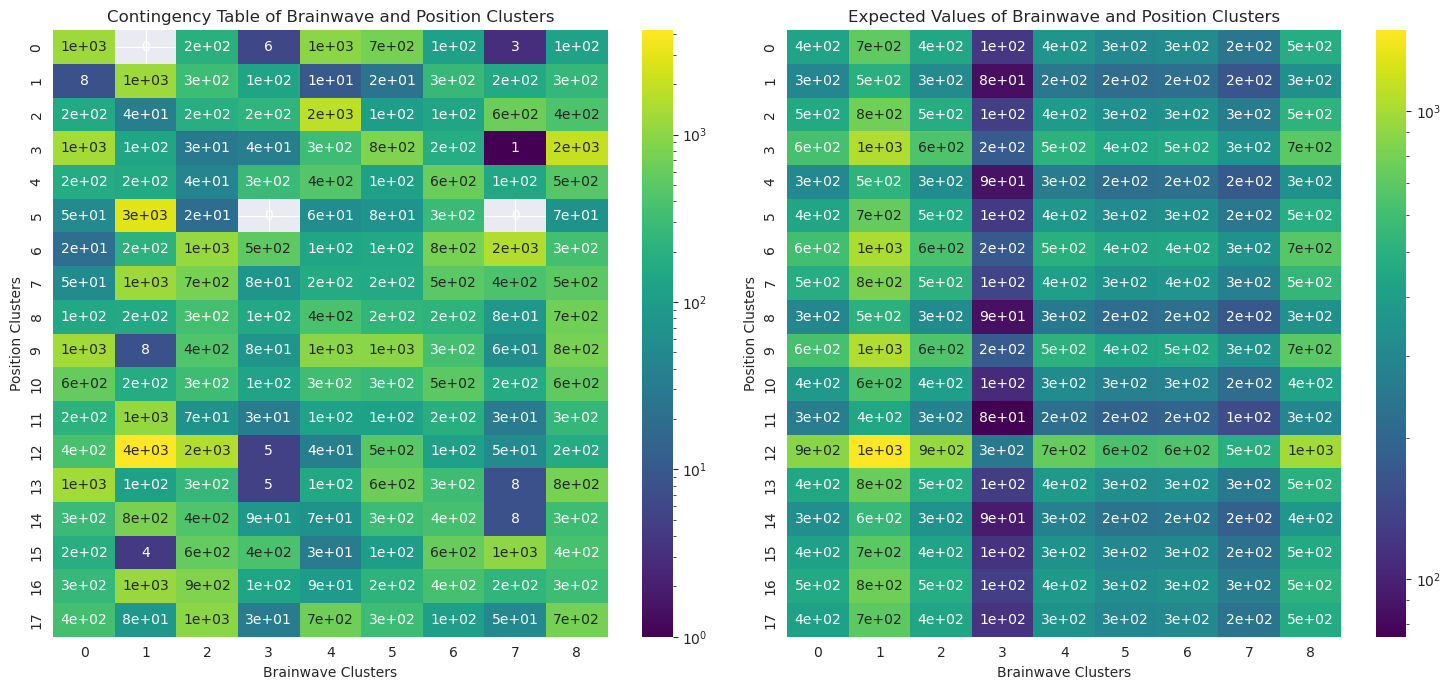

In [23]:
# Plot the contingency table and the expected values
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.heatmap(contingency_table, cmap='viridis', norm=LogNorm(), annot=True, fmt='.1g')
plt.title('Contingency Table of Brainwave and Position Clusters')
plt.xlabel('Brainwave Clusters')
plt.ylabel('Position Clusters')
plt.subplot(1, 2, 2)
sns.heatmap(ex, cmap='viridis', norm=LogNorm(), annot=True, fmt='.1g')
plt.title('Expected Values of Brainwave and Position Clusters')
plt.xlabel('Brainwave Clusters')
plt.ylabel('Position Clusters')
plt.tight_layout()
plt.savefig('graphs/contingency_table.png')
plt.show()

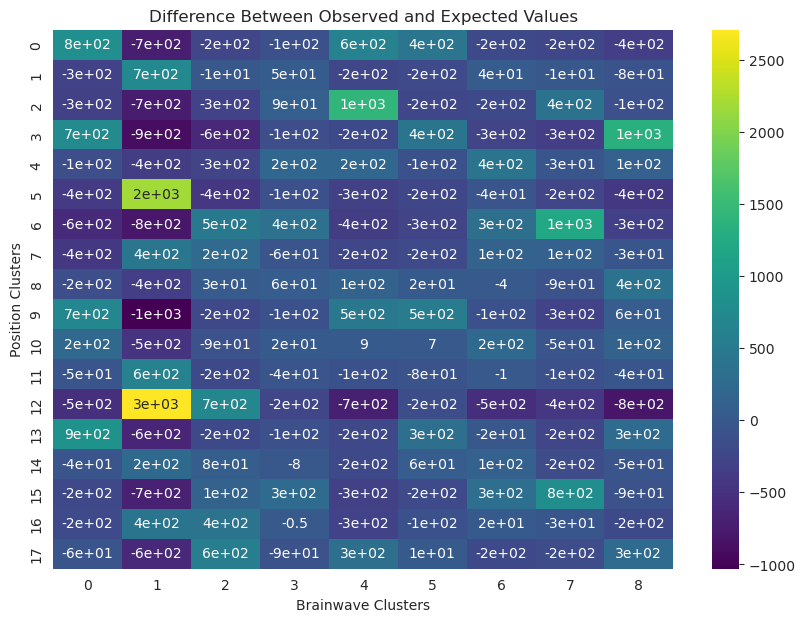

In [24]:
# Plot the difference between the observed and expected values
diff = contingency_table - ex
plt.figure(figsize=(10, 7))
sns.heatmap(diff, cmap='viridis', annot=True, fmt='.1g')
plt.title('Difference Between Observed and Expected Values')
plt.xlabel('Brainwave Clusters')
plt.ylabel('Position Clusters')
plt.savefig('graphs/difference.png')
plt.show()

In [25]:
# Calculate the contribution to the Chi-square statistic for each cell
chi2_contributions = (contingency_table - ex)**2 / ex

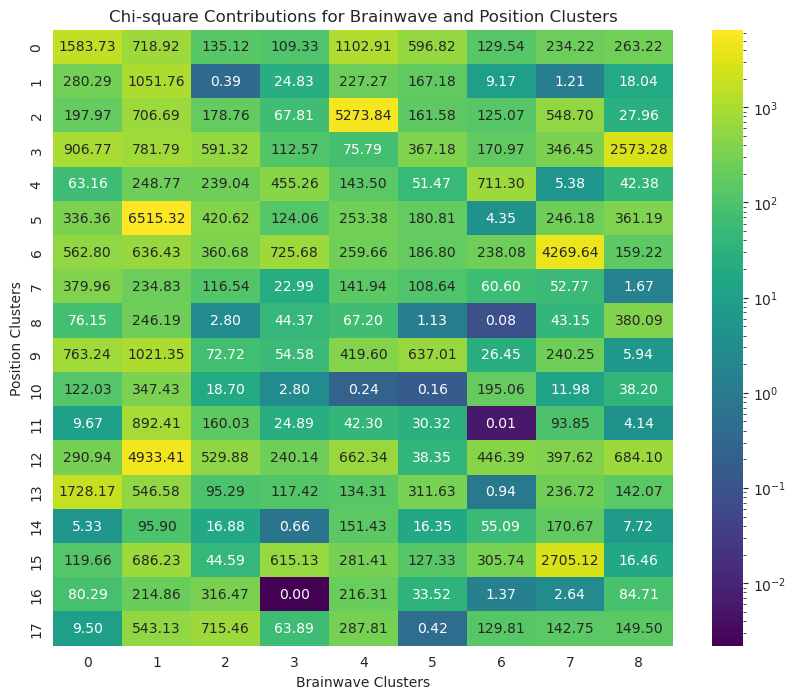

In [26]:
# Plot the contingency table with Chi-square contributions
plt.figure(figsize=(10, 8))
sns.heatmap(chi2_contributions, cmap='viridis', norm=LogNorm(), annot=True, fmt='.2f')
plt.title('Chi-square Contributions for Brainwave and Position Clusters')
plt.xlabel('Brainwave Clusters')
plt.ylabel('Position Clusters')
plt.savefig('graphs/chi2_contributions.png')
plt.show()

In [27]:
significance_level = 0.0000001 / chi2_contributions.size
critical_value = chi2.ppf(1 - significance_level, df=1)
significant_pairs = chi2_contributions > critical_value

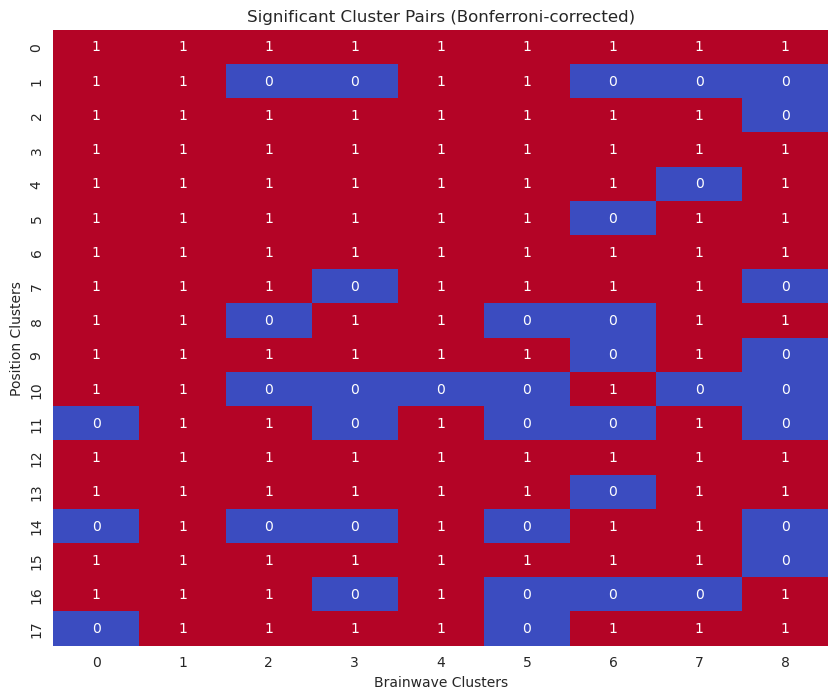

In [28]:
# Plot the significant pairs
plt.figure(figsize=(10, 8))
sns.heatmap(significant_pairs, cmap='coolwarm', annot=True, cbar=False)
plt.title('Significant Cluster Pairs (Bonferroni-corrected)')
plt.xlabel('Brainwave Clusters')
plt.ylabel('Position Clusters')
plt.savefig('graphs/significant_pairs.png')
plt.show()